In [49]:
%%time

import jax
import jax.numpy as jnp
import numpy as np

# Params
N, dx, dt = 1000, 0.2, 0.05    # Grid size, Δx, Δt
n_steps, n_save = 90000, 100   # Total steps, save interval

# Grids
x = jnp.arange(-N//2, N//2) * dx          # x = -L/2 to L/2
X, Y = jnp.meshgrid(x, x)                 # 2D real-space grid
k = 2*jnp.pi*jnp.fft.fftfreq(N, dx)       # k = 2π n / (N Δx)
KX, KY = jnp.meshgrid(k, k)               # 2D wavevector grid

# Initial ψ: Gaussian e^(-r²/2σ²) * e^(i k₀ x), σ=5, k₀=7
x0, y0 = 8.0, 0.0   # initial displacement (move up along Y)
px0, py0 = 0, -0.0  # initial momentum (pointing along X-axis)

# Initial Gaussian offset with initial momentum
psi = jnp.exp(-((X - x0)**2 + (Y - y0)**2)/(2 * 5**2)) * jnp.exp(1j * (px0 * X + py0 * Y))

psi /= jnp.sqrt(jnp.sum(jnp.abs(psi)**2))  # Normalize: ∫|ψ|² dx dy = 1

# Potential V = 10 ω² (x² + y²), ω = 0.05
V =  -30 * 0.05**2 / jnp.sqrt(X**2 + Y**2 + 0.2) 

# Kinetic phase: φ_k = e^(-i k² Δt / 2), k² = kx² + ky²
phi_k = jnp.exp(-1j * 0.5 * (KX**2 + KY**2) * dt/2)

# Split-Step Fourier step, Strang splitting: e^(i Δt (T + V)) ≈ e^(i Δt T/2) e^(i Δt V) e^(i Δt T/2)
@jax.jit
def split_step(psi, V, phi_k):
    # e^(i Δt T/2) ψ: FFT, multiply by φ_k, IFFT
    psi = jnp.fft.ifft2(jnp.fft.fft2(psi) * phi_k)
    # e^(i Δt V) ψ: Multiply by e^(-i V Δt)
    psi *= jnp.exp(-1j * V * dt)
    # e^(i Δt T/2) ψ: FFT, multiply by φ_k, IFFT
    psi = jnp.fft.ifft2(jnp.fft.fft2(psi) * phi_k)
    return psi

# Time evolution: i ∂ψ/∂t = (T + V) ψ
psi_sq = []
for t in range(n_steps):
    psi = split_step(psi, V, phi_k)
    if t % n_save == 0: psi_sq.append(np.array(jnp.abs(psi)**2))  # Save |ψ|²

print(f"Saved {len(psi_sq)} |ψ|² grids, shape {psi_sq[0].shape}")

Saved 900 |ψ|² grids, shape (1000, 1000)
CPU times: user 32.4 s, sys: 20 s, total: 52.4 s
Wall time: 44.7 s


In [204]:
import jax
import jax.numpy as jnp
import numpy as np

# Params
N, dx, dt = 1500, 0.1, 0.01
n_steps, n_save = 3000, 10

# Grids
x = jnp.arange(-N//2, N//2) * dx
X, Y = jnp.meshgrid(x, x)
k = 2*jnp.pi*jnp.fft.fftfreq(N, dx)
KX, KY = jnp.meshgrid(k, k)

# New potential: Double-well + Gaussian obstacle
a, b = 0.001, 10
c, d, s = 5.0, 0.0, 2.0
V = a*((X**2 - b)**2 + (Y**2 - b)**2) + c*jnp.exp(-((X - d)**2 + Y**2)/s**2)

# New initial conditions: Gaussian wave packet displaced and with momentum
x0, y0 = -10.0, 0.0
px0, py0 = 2.0, 1.5
sigma = 3.0

psi = jnp.exp(-((X - x0)**2 + (Y - y0)**2)/(2*sigma**2)) * jnp.exp(1j*(px0*X + py0*Y))
psi /= jnp.sqrt(jnp.sum(jnp.abs(psi)**2))

# Kinetic phase
phi_k = jnp.exp(-1j * 0.5 * (KX**2 + KY**2) * dt/2)

@jax.jit
def split_step(psi, V, phi_k):
    psi = jnp.fft.ifft2(jnp.fft.fft2(psi) * phi_k)
    psi *= jnp.exp(-1j * V * dt)
    psi = jnp.fft.ifft2(jnp.fft.fft2(psi) * phi_k)
    return psi

# Time evolution
psi_sq = []
for t in range(n_steps):
    psi = split_step(psi, V, phi_k)
    if t % n_save == 0:
        psi_sq.append(np.array(jnp.abs(psi)**2))

print(f"Saved {len(psi_sq)} |ψ|² grids, shape {psi_sq[0].shape}")

Saved 300 |ψ|² grids, shape (1500, 1500)


In [34]:
%%time

import jax
import jax.numpy as jnp
import numpy as np

# Params
N, dx, dt = 1000, 0.3, 0.1    # Grid size, Δx, Δt
n_steps, n_save = 1_000, 4   # Total steps, save interval

# Grids
x = jnp.arange(-N//2, N//2) * dx          # x = -L/2 to L/2
X, Y = jnp.meshgrid(x, x)                 # 2D real-space grid
k = 2*jnp.pi*jnp.fft.fftfreq(N, dx)       # k = 2π n / (N Δx)
KX, KY = jnp.meshgrid(k, k)               # 2D wavevector grid

# Initial ψ: Gaussian e^(-r²/2σ²) * e^(i k₀ x), σ=5, k₀=7
psi = jnp.exp(-(X**2 + Y**2)/(2*5**2)) * jnp.exp(1j*7*X)
psi /= jnp.sqrt(jnp.sum(jnp.abs(psi)**2))  # Normalize: ∫|ψ|² dx dy = 1

# Potential V = 10 ω² (x² + y²), ω = 0.05
V = 10 * 0.05**2 * (X**2 + Y**2)

# Kinetic phase: φ_k = e^(-i k² Δt / 2), k² = kx² + ky²
phi_k = jnp.exp(-1j * 0.5 * (KX**2 + KY**2) * dt/2)

# Split-Step Fourier step, Strang splitting: e^(i Δt (T + V)) ≈ e^(i Δt T/2) e^(i Δt V) e^(i Δt T/2)
@jax.jit
def split_step_first_order(psi, V, phi_k):
    psi = jnp.fft.ifft2(jnp.fft.fft2(psi) * phi_k)
    psi *= jnp.exp(-1j * V * dt)
    return psi

# Time evolution: i ∂ψ/∂t = (T + V) ψ
psi_sq = []
for t in range(n_steps):
    psi = split_step_first_order(psi, V, phi_k)
    if t % n_save == 0: psi_sq.append(np.array(jnp.abs(psi)**2))  # Save |ψ|²

print(f"Saved {len(psi_sq)} |ψ|² grids, shape {psi_sq[0].shape}")

Saved 250 |ψ|² grids, shape (1000, 1000)
CPU times: user 1.33 s, sys: 677 ms, total: 2.01 s
Wall time: 2.06 s


In [51]:
import pygame
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt  # for get_cmap, if needed

saved_frames = psi_sq

pygame.init()

# Parameters
fps = 30
clock = pygame.time.Clock()

# Pre-fetch the colormap. 256 = resolution of LUT
# You can pick any named colormap: 'magma','plasma','inferno','viridis','jet'
viridis_cmap = cm.get_cmap('inferno', 256)

# Suppose 'saved_frames' is a list or array of wavefunctions of shape (num_frames, Nx, Ny).
num_frames = len(saved_frames)
Nx, Ny = saved_frames[0].shape

screen = pygame.display.set_mode((Ny, Nx))
pygame.display.set_caption("Wavefunction with Viridis Colormap")

running = True
idx = 0

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Current frame
    wave = saved_frames[idx]
    prob = np.abs(wave)**2  # if wave is complex. If it's already real, skip abs**2.

    # Normalize each frame to [0..1] so colormap can apply
    vmax = prob.max()
    if vmax > 0:
        prob_norm = (prob / vmax)
    else:
        prob_norm = prob  # all zeros => black

    # Apply 'viridis' colormap -> returns RGBA in [0..1]
    rgba_data = viridis_cmap(prob_norm)  # shape (Nx, Ny, 4)

    # Convert to uint8 RGB (drop the alpha channel)
    rgb_data = (rgba_data[..., :3] * 255).astype(np.uint8)

    # Blit into pygame
    pygame.surfarray.blit_array(screen, rgb_data)
    pygame.display.flip()

    idx = (idx + 1) % num_frames
    clock.tick(fps)

pygame.quit()
print("Done.")


/tmp/ipykernel_585/2049076608.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis_cmap = cm.get_cmap('inferno', 256)
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5728:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) Unknown PCM default


Done.


In [198]:
import jax
import jax.numpy as jnp
import numpy as np

# Params
N, dx, dt = 1500, 0.1, 0.01
n_steps, n_save = 3000, 10

# Grids
x = jnp.arange(-N//2, N//2) * dx
X, Y = jnp.meshgrid(x, x)
k = 2*jnp.pi*jnp.fft.fftfreq(N, dx)
KX, KY = jnp.meshgrid(k, k)

# New potential: Double-well + Gaussian obstacle
a, b = 0.001, 10
c, d, s = 5.0, 0.0, 2.0
V = a*((X**2 - b)**2 + (Y**2 - b)**2) + c*jnp.exp(-((X - d)**2 + Y**2)/s**2)

# New initial conditions: Gaussian wave packet displaced and with momentum
x0, y0 = -10.0, 0.0
px0, py0 = 2.0, 1.5
sigma = 3.0

psi = jnp.exp(-((X - x0)**2 + (Y - y0)**2)/(2*sigma**2)) * jnp.exp(1j*(px0*X + py0*Y))
psi /= jnp.sqrt(jnp.sum(jnp.abs(psi)**2))

# Kinetic phase
phi_k = jnp.exp(-1j * 0.5 * (KX**2 + KY**2) * dt/2)

@jax.jit
def split_step(psi, V, phi_k):
    psi = jnp.fft.ifft2(jnp.fft.fft2(psi) * phi_k)
    psi *= jnp.exp(-1j * V * dt)
    psi = jnp.fft.ifft2(jnp.fft.fft2(psi) * phi_k)
    return psi

# Time evolution
psi_sq = []
for t in range(n_steps):
    psi = split_step_first_order(psi, V, phi_k)
    if t % n_save == 0:
        psi_sq.append(np.array(jnp.abs(psi)**2))

print(f"Saved {len(psi_sq)} |ψ|² grids, shape {psi_sq[0].shape}")

Saved 300 |ψ|² grids, shape (1500, 1500)


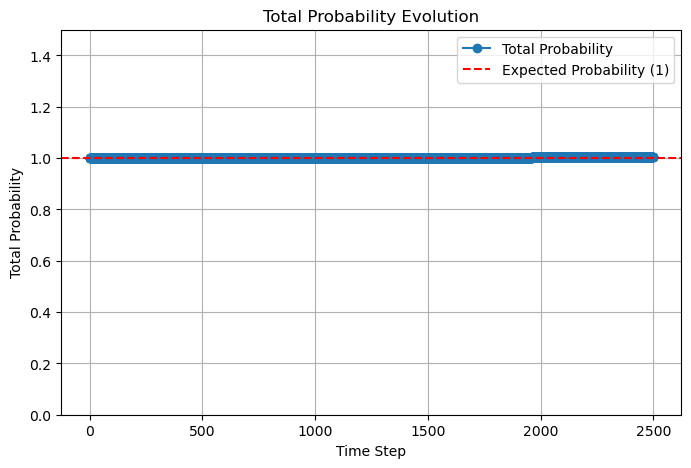

In [73]:
import matplotlib.pyplot as plt

# Assuming psi_sq is a list of NumPy arrays representing |ψ|^2 at each time step
# psi_sq should already be defined in your workspace


total_probs = [x.sum() for x in psi_sq]  # Compute total probability at each time step

# Plot the total probability as a function of time steps
plt.figure(figsize=(8, 5))
plt.plot(range(len(total_probs)), total_probs, marker='o', linestyle='-', label="Total Probability")
plt.axhline(y=1, color='r', linestyle='--', label="Expected Probability (1)")
plt.xlabel('Time Step')
plt.ylabel('Total Probability')
plt.title('Total Probability Evolution')
plt.ylim(0, 1.5)  # Set y-axis limits between 0 and 1
plt.legend()
plt.grid(True)
plt.show()

In [68]:
%%time

import jax
import jax.numpy as jnp
import numpy as np

# Params
N, dx, dt = 1000, 0.1, 0.0001     # Grid size, Δx, Δt
n_steps, n_save = 150000, 800   # Total steps, save interval

# Grids
x = jnp.arange(-N//2, N//2) * dx          # x = -L/2 to L/2
X, Y = jnp.meshgrid(x, x)                 # 2D real-space grid
k = 2*jnp.pi*jnp.fft.fftfreq(N, dx)       # k = 2π n / (N Δx)
KX, KY = jnp.meshgrid(k, k)               # 2D wavevector grid

# Initial ψ: Gaussian e^(-r²/2σ²) * e^(i k₀ x), σ=5, k₀=7
psi = jnp.exp(-(X**2 + Y**2)/(2*5**2)) * jnp.exp(1j*7*X)
psi /= jnp.sqrt(jnp.sum(jnp.abs(psi)**2))  # Normalize: ∫|ψ|² dx dy = 1

# Potential V = 10 ω² (x² + y²), ω = 0.05
V = 10 * 0.05**2 * (X**2 + Y**2)

# Kinetic phase: φ_k = e^(-i k² Δt / 2), k² = kx² + ky²
phi_k = jnp.exp(-1j * 0.5 * (KX**2 + KY**2) * dt/2)

# Split-Step Fourier step, Strang splitting: e^(i Δt (T + V)) ≈ e^(i Δt T/2) e^(i Δt V) e^(i Δt T/2)
@jax.jit
def forward_step(psi, V, h, dt):
    # Compute the Laplacian using a five-point stencil with periodic boundaries
    laplacian = (jnp.roll(psi, 1, axis=0) + jnp.roll(psi, -1, axis=0) +
                 jnp.roll(psi, 1, axis=1) + jnp.roll(psi, -1, axis=1) - 4 * psi) / (h ** 2)
    
    # Apply the Hamiltonian: H ψ = - (1/2) ∇² ψ + V ψ
    H_psi = -0.5 * laplacian + V * psi
    
    # Forward Euler step: ψ^{n+1} = ψ^n - i dt H ψ^n
    psi_new = psi - 1j * dt * H_psi
    
    return psi_new

# Time evolution: i ∂ψ/∂t = (T + V) ψ
psi_sq = []
for t in range(n_steps):
    psi = forward_step(psi, V, dx, dt)
    if t % n_save == 0: psi_sq.append(np.array(jnp.abs(psi)**2))  # Save |ψ|²

print(f"Saved {len(psi_sq)} |ψ|² grids, shape {psi_sq[0].shape}")

Saved 188 |ψ|² grids, shape (1000, 1000)
CPU times: user 27.8 s, sys: 30.6 s, total: 58.5 s
Wall time: 31.5 s


In [14]:
%%time

import jax
import jax.numpy as jnp
import numpy as np
from jax.scipy.sparse.linalg import gmres
from functools import partial

# Parameters
N, dx, dt = 1000, 0.1, 0.005      # Grid size, spatial step Δx, time step Δt
n_steps, n_save = 4000, 10     # Total steps, save interval

# Spatial and wavevector grids
x = jnp.arange(-N // 2, N // 2) * dx        # x from -L/2 to L/2
X, Y = jnp.meshgrid(x, x)                   # 2D real-space grid
k = 2 * jnp.pi * jnp.fft.fftfreq(N, dx)     # k = 2π n / (N Δx)
KX, KY = jnp.meshgrid(k, k)                 # 2D wavevector grid

# Initial wavefunction: Gaussian e^(-r²/(2σ²)) * e^(i k₀ x), σ=5, k₀=7
psi = jnp.exp(-(X**2 + Y**2) / (2 * 5**2)) * jnp.exp(1j * 7 * X)
psi /= jnp.sqrt(jnp.sum(jnp.abs(psi)**2))  # Normalize ∫|ψ|² dx dy = 1

# Potential: V = 10 ω² (x² + y²), ω = 0.05
V = 10 * (0.05**2) * (X**2 + Y**2)

# Kinetic phase for reference (unused here but kept for context)
phi_k = jnp.exp(-1j * 0.5 * (KX**2 + KY**2) * dt / 2)

def apply_hamiltonian(psi_flat, V_flat, h, N):
    """Apply Hamiltonian H = -1/2 ∇² + V to flattened psi."""
    psi = psi_flat.reshape((N, N))
    laplacian = (jnp.roll(psi, 1, axis=0) + jnp.roll(psi, -1, axis=0) +
                 jnp.roll(psi, 1, axis=1) + jnp.roll(psi, -1, axis=1) - 4 * psi) / (h ** 2)
    H_psi = -0.5 * laplacian + V_flat.reshape((N, N)) * psi
    return H_psi.flatten()

@partial(jax.jit, static_argnums=(4,))
def backward_step(psi, V, h, dt, N):
    """Backward Euler step for Schrödinger equation time evolution.
    
    Args:
        psi: 2D complex array, current wavefunction
        V: 2D real array, potential energy
        h: float, spatial grid spacing
        dt: float, time step size
        N: int, grid size (N × N)
    
    Returns:
        psi_new: 2D complex array, wavefunction at next time step
    """
    psi_flat = psi.flatten()
    V_flat = V.flatten()
    
    def A_func(psi_next_flat):
        """Define A ψ^{n+1} = ψ^n: ψ^{n+1} - i dt H ψ^{n+1}"""
        H_psi = apply_hamiltonian(psi_next_flat, V_flat, h, N)
        return psi_next_flat - 1j * dt * H_psi
    
    # Solve A ψ^{n+1} = ψ^n with GMRES
    psi_next_flat, _ = gmres(A_func, psi_flat, tol=1e-5)
    return psi_next_flat.reshape((N, N))

CPU times: user 21.9 ms, sys: 98 μs, total: 22 ms
Wall time: 18.5 ms


In [16]:
%%time

# Time evolution: i ∂ψ/∂t = (T + V) ψ
psi_sq = []
for t in range(100):
    psi = backward_step(psi, V, dx, dt, N)
    if t % n_save == 0:
        psi_sq.append(np.array(jnp.abs(psi)**2))  # Store |ψ|²

print(f"Saved {len(psi_sq)} |ψ|² grids, shape {psi_sq[0].shape}")

Saved 10 |ψ|² grids, shape (1000, 1000)
CPU times: user 16.7 s, sys: 158 ms, total: 16.8 s
Wall time: 16.8 s


In [3]:
%%time

import jax
import jax.numpy as jnp
from jax.experimental import sparse
from jax.scipy.sparse.linalg import gmres
import numpy as np

# Params
N, dx, dt = 1000, 0.1, 0.05    # Grid size, Δx, Δt
n_steps, n_save = 100, 4   # Total steps, save interval

# Grids
x = jnp.arange(-N//2, N//2) * dx    # x = -L/2 to L/2
X, Y = jnp.meshgrid(x, x)           # 2D real-space grid

# Initial ψ: e^(-r²/2σ²) * e^(i k₀ x)
psi = jnp.exp(-(X**2 + Y**2)/(2*1**2)) * jnp.exp(1j*2*X)
psi /= jnp.sqrt(jnp.sum(jnp.abs(psi)**2))  # Normalize: ∫|ψ|² dx dy = 1

# V = 10 ω² (x² + y²)
V = 10 * 0.05**2 * (X**2 + Y**2)

# Crank-Nicolson: A ψ^{n+1} = B ψ^n
r = 1j * dt / (4 * dx**2)  # 2.5i
off_diag_a = -r            # -2.5i
off_diag_b = r             # 2.5i

def make_cn_matrix(N, diag_base, V, off_diag):
    N2 = N * N
    j, k = jnp.divmod(jnp.arange(N2), N)
    diag_idx = jnp.stack([jnp.arange(N2), jnp.arange(N2)], axis=1)
    mask_left = k > 0
    mask_right = k < N-1
    mask_up = j > 0
    mask_down = j < N-1
    left_idx = jnp.stack([jnp.arange(N2)[mask_left], (jnp.arange(N2) - 1)[mask_left]], axis=1)
    right_idx = jnp.stack([jnp.arange(N2)[mask_right], (jnp.arange(N2) + 1)[mask_right]], axis=1)
    up_idx = jnp.stack([jnp.arange(N2)[mask_up], (jnp.arange(N2) - N)[mask_up]], axis=1)
    down_idx = jnp.stack([jnp.arange(N2)[mask_down], (jnp.arange(N2) + N)[mask_down]], axis=1)
    indices = jnp.concatenate([diag_idx, left_idx, right_idx, up_idx, down_idx])
    diag_vals = diag_base - 1j * dt * V.flatten() / 2
    values = jnp.concatenate([
        diag_vals,
        off_diag * jnp.ones(len(left_idx)),
        off_diag * jnp.ones(len(right_idx)),
        off_diag * jnp.ones(len(up_idx)),
        off_diag * jnp.ones(len(down_idx))
    ])
    return sparse.BCOO((values, indices), shape=(N2, N2))

A = make_cn_matrix(N, 1 + 4 * r, V, off_diag_a)
B = make_cn_matrix(N, 1 - 4 * r, V, off_diag_b)

# Jitted step
@jax.jit
def crank_nicolson_step(psi_flat, A, B):
    rhs = B @ psi_flat  # B ψ^n
    psi_next_flat = gmres(A, rhs, tol=1e-5)[0]  # A^{-1} B ψ^n
    return psi_next_flat

# Time evolution
psi_flat = psi.flatten()
psi_sq = []
for t in range(n_steps):
    psi_flat = crank_nicolson_step(psi_flat, A, B)
    if t % n_save == 0:
        psi = psi_flat.reshape(N, N)
        psi_sq.append(np.array(jnp.abs(psi)**2))

print(f"Saved {len(psi_sq)} |ψ|² grids, shape {psi_sq[0].shape}")

Saved 25 |ψ|² grids, shape (1000, 1000)
CPU times: user 21.4 s, sys: 331 ms, total: 21.8 s
Wall time: 23.3 s


In [ ]:
%%time

# Time evolution
psi_flat = psi.flatten()
psi_sq = []
for t in range(2_000):
    psi_flat = crank_nicolson_step(psi_flat, A, B)
    if t % n_save == 0:
        psi = psi_flat.reshape(N, N)
        psi_sq.append(np.array(jnp.abs(psi)**2))

print(f"Saved {len(psi_sq)} |ψ|² grids, shape {psi_sq[0].shape}")

In [2]:
import jax
import jax.numpy as jnp
from jax.experimental import sparse
from jax.scipy.sparse.linalg import gmres

# Parameters
N, dx, dt = 500, 0.1, 0.05  # Smaller grid for simplicity
n_steps, n_save = 1000, 10  # Fewer steps, less frequent saves

# Grid
x = jnp.arange(-N//2, N//2) * dx
X, Y = jnp.meshgrid(x, x)

# Initial wave function: Gaussian
psi = jnp.exp(-(X**2 + Y**2))
psi = psi / jnp.sqrt(jnp.sum(jnp.abs(psi)**2))  # Normalize

# Potential: Harmonic oscillator
V = 0.0 * (X**2 + Y**2)  # Set to zero for simplicity

# 2D Laplacian using sparse diagonals
I = sparse.eye(N)
d2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(N, N)) / dx**2
laplacian = sparse.kron(I, d2) + sparse.kron(d2, I)

# Hamiltonian
H = -0.5 * laplacian + sparse.diags(V.ravel())  # hbar = m = 1

# Crank-Nicolson matrices
I_tot = sparse.eye(N * N)
A = I_tot + 1j * dt / 2 * H
B = I_tot - 1j * dt / 2 * H

# Jitted step function
@jax.jit
def step(psi_flat):
    rhs = B @ psi_flat
    return gmres(A, rhs, tol=1e-5)[0]

# Time evolution
psi_flat = psi.ravel()
psi_sq = []
for t in range(n_steps):
    psi_flat = step(psi_flat)
    if t % n_save == 0:
        psi_sq.append(jnp.abs(psi_flat.reshape(N, N))**2)

print(f"Saved {len(psi_sq)} |ψ|² grids, shape {psi_sq[0].shape}")

AttributeError: module 'jax.experimental.sparse' has no attribute 'diags'

In [21]:
%%time

import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as splinalg

# Constants
hbar, m = 1.0, 1.0
nx, ny = 1000, 1000
dx, dy = 0.1, 0.1
dt = 0.4

# Grid
x = np.linspace(-2, 2, nx)
y = np.linspace(-2, 2, ny)
X, Y = np.meshgrid(x, y)

# Potential (Example: Harmonic oscillator)
V = 0.0 * (X**2 + Y**2)

# Initial wave function (Gaussian)
psi = np.exp(-X**2 - Y**2).ravel()
psi /= np.linalg.norm(psi)

# 2D Laplacian operator
Ix = sparse.eye(nx)
Iy = sparse.eye(ny)
dx2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(nx, nx)) / dx**2
dy2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(ny, ny)) / dy**2
laplacian = sparse.kron(Iy, dx2) + sparse.kron(dy2, Ix)

# Hamiltonian
H = -(hbar**2 / (2 * m)) * laplacian + sparse.diags(V.ravel())

# Crank-Nicolson matrices
I = sparse.eye(nx * ny)
A = I + 1j * dt / (2 * hbar) * H
B = I - 1j * dt / (2 * hbar) * H

# Time stepping (simple example, 100 steps)
for _ in range(10):
    psi, info = splinalg.gmres(A, B @ psi, rtol=1e-5)

psi_final = psi.reshape((ny, nx))

CPU times: user 30min 49s, sys: 2.19 s, total: 30min 51s
Wall time: 58.1 s
